<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Experiments/Experiment%20%5B4%5D%20%7BVision%7D%20-%20Compression%20and%20Reconstruction%20using%20Eigen%20Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References
*   https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf
*   https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py


*   https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184

*   https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com

Eigen Faces is an algorithm which uses PCA for Facial recognition and compression.

The idea is to find Eigen Vectors among 10K images (perfectly aligned faces, i.e its limitation, check web for samples, also how it can be done automatically.). Then compute a mean face which is just an average of all the faces and then subtract average face from eigen vectors. 

The coefficient of the eigen vectors can then be used to compress face image,as they represent maximum information of an face and we can recon struct the face using just these values. 

### Download Datasets

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset_dir = "/content/drive/My Drive/datasets/eigen_face"

import os
if not os.path.exists(dataset_dir):
  os.makedirs(dataset_dir)

In [0]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
!mv lfw-funneled.tgz "$dataset_dir"

!tar -xf "$dataset_dir/lfw-funneled.tgz" -C "$dataset_dir"
!rm "$dataset_dir/lfw-funneled.tgz"

--2020-06-04 07:04:00--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  14.7MB/s    in 25s     

2020-06-04 07:04:26 (9.16 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



### Prepare dataset

Now the tarfile is downloaded and extracted lets put it in X, Y form that is common

In [0]:
def recurse_img_path(directory):
    paths = [os.path.join(directory, path) for path in os.listdir(directory)]

    paths_dir = list(filter(lambda x: os.path.isdir(x), paths))
    paths_files = list(filter(lambda x: os.path.isfile(x) and 'jpg' in x.lower(), paths))

    paths_dir_files = []
    for path_dir in paths_dir:
        paths_dir_files.extend(recurse_img_path(path_dir))

    return paths_files + paths_dir_files

images_paths = recurse_img_path(dataset_dir)
print(len(images_paths), images_paths[0:2])

13233 ['/content/drive/My Drive/datasets/eigen_face/lfw_funneled/Richard_Hellfant/Richard_Hellfant_0001.jpg', '/content/drive/My Drive/datasets/eigen_face/lfw_funneled/Richard_Krajicek/Richard_Krajicek_0002.jpg']


We have lots of faces lets convert them in X, Y
<pre>
X -> N * P  => num_samples, num pixels
Y -> N      => Num_samples (labels present in directory_name)
</pre>

Lets loose colour information for now and focus on greyscale image

In [0]:
import cv2
import numpy as np

N  = len(images_paths) # Num images we want to load
N = 5000

X = np.array([cv2.imread(image_path, 0).reshape(-1) for image_path in images_paths[0:N]])
Y = np.array([os.path.basename(os.path.dirname(image_path)) for image_path in images_paths[0:N]])

print(X.shape, Y.shape)

(5000, 62500) (5000,)


Lets Remove classes with only 1 sample, so that our StratifiedShuffleSplit doesnt throw any error

In [0]:
# print(np.array(np.unique(Y, return_counts=True)).T)
p_indexs = list(range(0, Y.shape[0]))
for name, count in np.array(np.unique(Y, return_counts=True)).T:
    if count == '1':
        index = np.where(Y==name)[0]
        p_indexs.remove(index[0])

print("Shape Before removing 1 sample class", X.shape, Y.shape)        
X = X[p_indexs]
Y = Y[p_indexs]
print("Shape After removing 1 sample class", X.shape, Y.shape)        

Shape Before removing 1 sample class (5000, 62500) (5000,)
Shape After removing 1 sample class (3434, 62500) (3434,)


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
clf_s = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in clf_s.split(X, Y):
  # print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]
print("Train", X_train.shape, Y_train.shape)
print("Test", X_test.shape, Y_test.shape)

Train (2747, 62500) (2747,)
Test (687, 62500) (687,)


### PCA time

**Mean Image of all the samples**

Lets take a mean of all the images and See its looks like

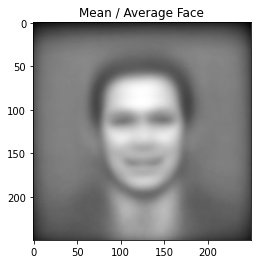

In [0]:
mean = np.mean(X_train, axis=0)
plt.title("Mean / Average Face")
plt.imshow(mean.reshape((H, W)), cmap=plt.cm.gray)
# plt.imshow(pca.mean_.reshape((H, W)), cmap=plt.cm.gray)  ## -- 2nd Way

**PCA and Eigen Faces**

Lets fit our PCA on our dataset and see if we can reduce the dimentionality and thus able to compress the information about a face in few dimention rather then 62500 pixels which are required now.

n_component will actually tell us total number of eigen vectors which we are going to generate, from which we can generate n_component *Eigen Faces*


(2747, 62500)
Component Shape: (100, 62500)


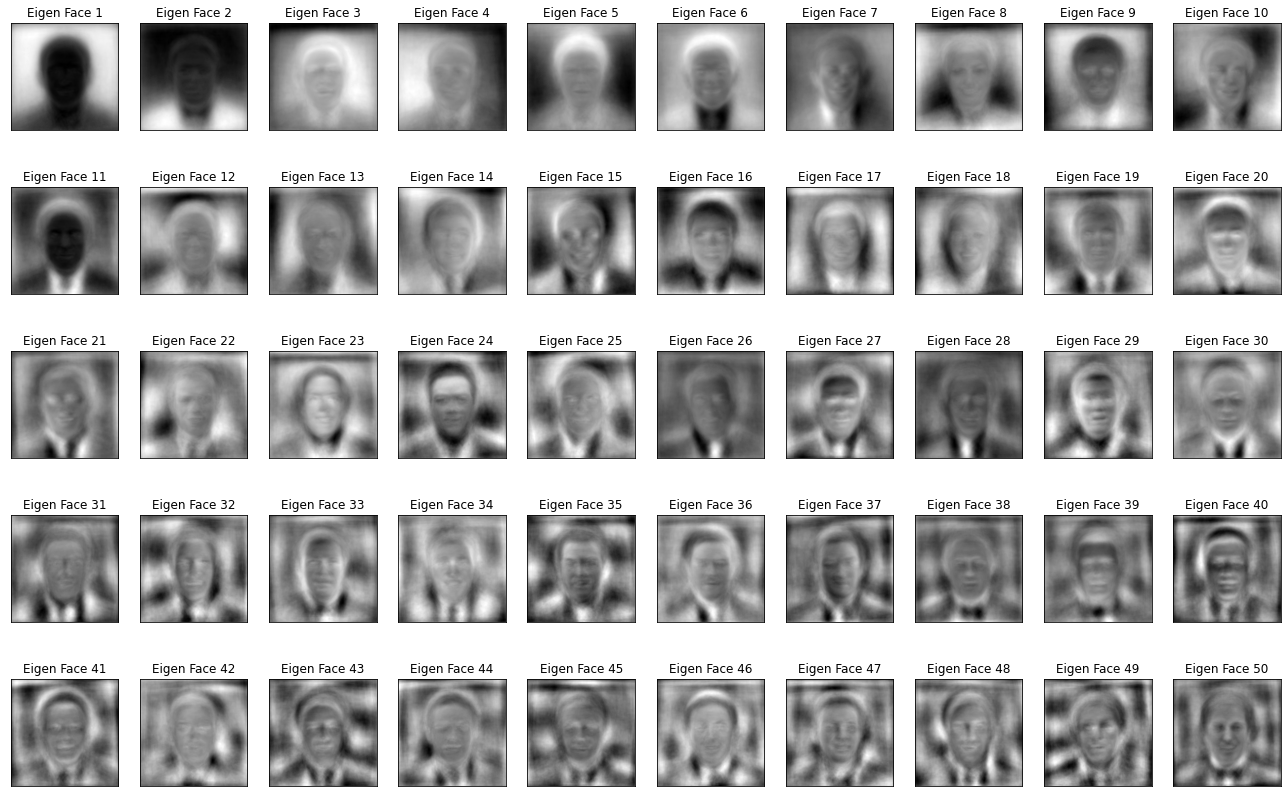

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print(X_train.shape)

# mean = np.mean(X_train, axis=0)

def train_pca(n_components):
    pca = PCA(n_components=n_components).fit(X_train)

    ''' Now since we have decided to have n_components, each one of these components will act as an Eigen Face,
    If we increase the number of components the quality of reconstruction and recognition will be much better '''

    print("Component Shape:", pca.components_.shape)
    return pca

n_components = 100
pca = train_pca(100)

H, W =  int(X_train.shape[1] ** 0.5),  int(X_train.shape[1] ** 0.5)
eigenfaces = pca.components_.reshape((n_components, H, W))

''' Lets Plot the Eigen Faces '''
def plot_gallery(images, h, w, n_row, n_col):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.title("Eigen Face %s" % str(i + 1))
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

# Plotting 50 Eigen Faces
plot_gallery(eigenfaces[0:50], H, W, n_row=5, n_col=10)

Above Eigen Faces look like Ghost images, the idea is that we can generate any faces as a combination of above faces. 

Each of these principal components can explain some variation in the original dataset. The parameter components_ of the classifier object gives the components with maximum variance

In [0]:
print("Variance Retained After PCA:", np.sum(pca.explained_variance_ratio_))

Variance Retained After PCA: 0.8548477024854372


**PCA - 100, 150, 200, 500, 1000**

Lets generate pca with different n range to see effect of freedom on quality of PCA components, the idea is we will reconstruct the original image with different n value and see if adding more n increase the reconstruction quality

In [0]:
pca_100, pca_150, pca_200, pca_500, pca_1000 = train_pca(100), train_pca(150), train_pca(200), train_pca(500), train_pca(1000)

print("Variance Retained After PCA(100):", np.sum(pca_100.explained_variance_ratio_))
print("Variance Retained After PCA(150):", np.sum(pca_150.explained_variance_ratio_))
print("Variance Retained After PCA(200):", np.sum(pca_200.explained_variance_ratio_))
print("Variance Retained After PCA(500):", np.sum(pca_500.explained_variance_ratio_))
print("Variance Retained After PCA(1000):", np.sum(pca_1000.explained_variance_ratio_))

Component Shape: (100, 62500)
Component Shape: (150, 62500)
Component Shape: (200, 62500)
Component Shape: (500, 62500)
Component Shape: (1000, 62500)
Variance Retained After PCA(100): 0.8548356498809166
Variance Retained After PCA(150): 0.8860863680982765
Variance Retained After PCA(200): 0.9057999155524453
Variance Retained After PCA(500): 0.9561765170273032
Variance Retained After PCA(1000): 0.9822196440376417


### Reconstrucion

Lets Pick one face and try compress and then reconstruct it

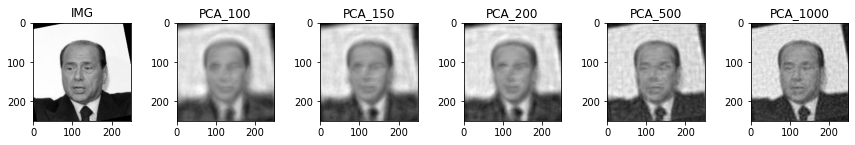

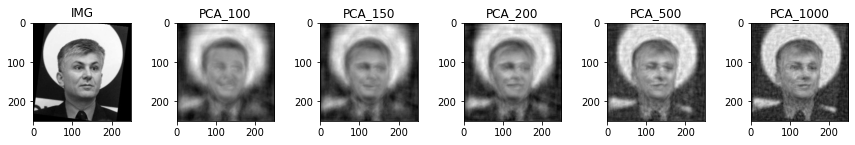

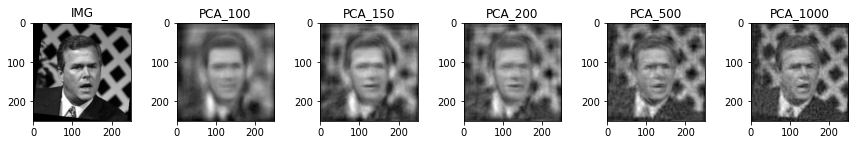

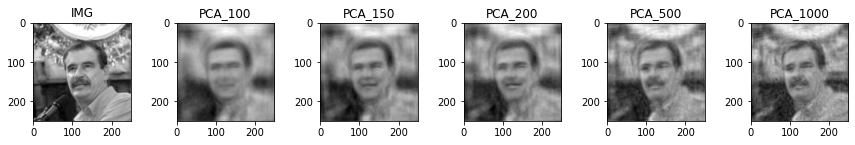

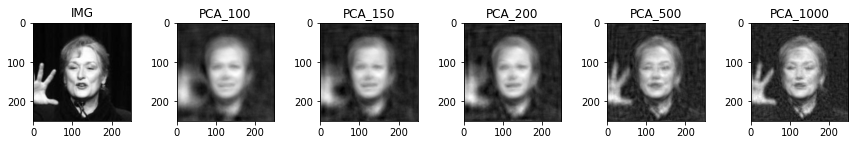

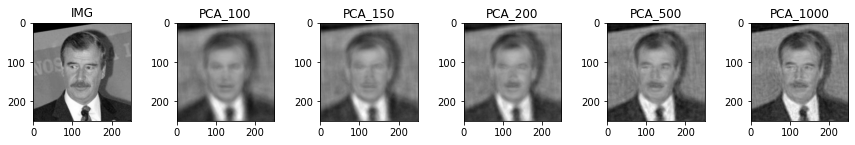

In [0]:
def reconstruct(pca_dict, k):

    # print("Compressed information:", pca.transform([X_test[k]]).shape, "\nEigen Faces:", pca.components_.shape)
    original_image = X_test[k]
    H, W =  int(original_image.shape[0] ** 0.5),  int(original_image.shape[0] ** 0.5)

    ''' To get the reconstructed face we dot multiply the transformed/comressed image with pca.components_ and the we add the mean image
        reconstructed_images = np.dot(pca.transform(original_image),  pca_components) + mean_image
    '''

    reconstructed_image_100 = np.dot(pca_dict['100'].transform([original_image]), pca_dict['100'].components_).reshape((H, W))  +  pca_dict['100'].mean_.reshape((H, W))
    reconstructed_image_150 = np.dot(pca_dict['150'].transform([original_image]), pca_dict['150'].components_).reshape((H, W))  +  pca_dict['150'].mean_.reshape((H, W))
    reconstructed_image_200 = np.dot(pca_dict['200'].transform([original_image]), pca_dict['200'].components_).reshape((H, W))  +  pca_dict['200'].mean_.reshape((H, W))
    reconstructed_image_500 = np.dot(pca_dict['500'].transform([original_image]), pca_dict['500'].components_).reshape((H, W))  +  pca_dict['500'].mean_.reshape((H, W))
    reconstructed_image_1000 = np.dot(pca_dict['1000'].transform([original_image]), pca_dict['1000'].components_).reshape((H, W))  +  pca_dict['1000'].mean_.reshape((H, W))

    # plt.imshow(eigen_faces_weighted_sum.reshape((H, W)), cmap=plt.cm.gray)
    # plt.title("Original, pca_100, pca_150, pca_200")

    n_row = 1
    n_col = 6

    plt.figure(figsize=(2.5 * n_col, 1.8 * n_row))
    # plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.50)

    def plot_n(title, img, row, col, i):
        plt.subplot(row, col, i)
        plt.title(title)
        plt.imshow(img, cmap=plt.cm.gray)

    plot_n("IMG", original_image.reshape((H, W)), 1, n_col, 1)
    plot_n("PCA_100", reconstructed_image_100, n_row, n_col, 2)
    plot_n("PCA_150", reconstructed_image_150, n_row, n_col, 3)
    plot_n("PCA_200", reconstructed_image_200, n_row, n_col, 4)
    plot_n("PCA_500", reconstructed_image_500, n_row, n_col, 5)
    plot_n("PCA_1000", reconstructed_image_1000, n_row, n_col, 6)

    # plt.imshow(np.hstack([original_image.reshape((H, W)),
    #                       reconstructed_image_100,
    #                       reconstructed_image_150,
    #                       reconstructed_image_200]), cmap=plt.cm.gray)

    # Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
    plt.show()

indexes = [10, 11, 21, 24, 43, 120]
pca_dict = {'100': pca_100, '150': pca_150, '200': pca_200, '500': pca_500, '1000': pca_1000}
for i in indexes:
    reconstruct(pca_dict, i)